In [1]:
# sources:
# https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html#sphx-glr-auto-examples-object-detection-camera-py

# k-means clustering
# https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python

# drawing clusters:
# https://docs.opencv.org/master/d0/d86/tutorial_py_image_arithmetics.html

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
tf.get_logger().setLevel('ERROR')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import operator
%matplotlib inline
#inline 
#notebook

In [2]:
PATH_TO_LABELS = '../training_v2/annotations/label_map.pbtxt'
PATH_TO_CKPT = '../training_v2/exported-models/my_ssd_resnet50_v1_fpn_export/checkpoint'
PATH_TO_CFG = '../training_v2/exported-models/my_ssd_resnet50_v1_fpn_export/pipeline.config'

In [3]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()
        
# cropping the image to the size of the box
def crop_image(img, box):
    ymin, xmin, ymax, xmax = box
    crop_image = img[int(ymin*img.shape[0]):int(ymax*img.shape[0]), int(xmin*img.shape[1]):int(xmax*img.shape[1])]
    return crop_image

# convert image from BGR to RBG
def convert_bgr2rgb(img):
    conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return conv_img

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

In [4]:
# perform k-mean clustering on cropped image:
def perform_clustering(image):
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    k = 4
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers = np.uint8(centers)
    # flatten the labels array
    labels = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

# add clustered pixels to original frame
def diplay_cluster(img1, img2, box):
    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[int(box[0]*img1.shape[0]):rows+int(box[0]*img1.shape[0]), int(box[1]*img1.shape[1]):cols+int(box[1]*img1.shape[1])]
    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    
    # get biggest cluster:
    #print(np.unique(img2gray))
#     sum_of_pixe_per_cluster = {}
#     for i in np.unique(img2gray):
#         sum_of_pixe_per_cluster[str(i)] = sum(img2gray.flatten() == i)
    
    value = max(np.unique(img2gray))
    
    #print(sum_of_pixe_per_cluster)
    
    if value >199:
        ret, mask = cv2.threshold(img2gray, 199, 255, cv2.THRESH_BINARY)
    else:
        print(value)
        ret, mask = cv2.threshold(img2gray, value-1, value+1, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    img1[int(box[0]*img1.shape[0]):rows+int(box[0]*img1.shape[0]), int(box[1]*img1.shape[1]):cols+int(box[1]*img1.shape[1])] = dst
    return img1, mask_inv

In [5]:
# predict and plot:
def predict_and_plot(image_name):
    
    ################### read in image:
    frame = np.array(Image.open('original_frames/' +image_name))
    
    ################### transform color:
    #print(frame.shape)
    
    ################### plot original:
    plt.imshow(frame)
    plt.show()
    
    ################### plot label image and label size:
    label_frame = np.array(Image.open('annotated_frames/' +image_name))
    
    label_mask = cv2.cvtColor(label_frame,cv2.COLOR_BGR2GRAY)
    label_mask[label_mask != 46] = 0
    label_mask[label_mask == 46] = 213

    label_size = sum(label_mask.flatten() != 0)
    plt.imshow(label_frame)
    plt.show()
    #print(label_size)
    
    ################### make prediction: 
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(frame, axis=0)

    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = frame.copy()
    image, box = viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=.30,
        agnostic_mode=False)
    
    if box[0] != 0:
        croped_img = crop_image(image_np_with_detections, box)
        cluster_image = perform_clustering(croped_img)
        plt.imshow(cluster_image)
        plt.show()
        full_image, pred_mask = diplay_cluster(image, cluster_image, box)
        pred_mask = cv2.bitwise_not(pred_mask)
        pred_mask[pred_mask != 0] = 213
    else:
        full_image = image
        pred_mask = []

    
    ################### plot prediction and print predicted size:
    plt.imshow(full_image)
    plt.show()
    if len(pred_mask) != 0:
        splash_size = sum(pred_mask.flatten() != 0)
        #print(splash_size)
    else:
        print('no splash')
    
    ################### calculate difference between original and prediction and accuracy
    if len(pred_mask) != 0:
        rows,cols,channels = frame.shape
        empty_image = np.zeros((rows,cols), np.uint8)
        empty_image[int(box[0]*rows):int(box[2]*rows), int(box[1]*cols):int(box[3]*cols)] = pred_mask
        diff = cv2.absdiff(label_mask, empty_image)
        plt.imshow(label_mask)
        plt.show()
        plt.imshow(empty_image)
        plt.show()
        plt.imshow(diff)
        plt.show()
        diff_size = sum(diff.flatten() != 0)
        #print(diff_size)
        accuracy = round((label_size - diff_size) / label_size,4)
        
    ################### safe calculation to a dictionairy
    frame_info = {
        'frame_name': image_name,
        'label_size': label_size,
    }
    if len(pred_mask) != 0:
        frame_info['splash_size'] = splash_size
        frame_info['diff_size'] = diff_size
        frame_info['accuracy'] = accuracy
    else:
        frame_info['splash_size'] = 0
        frame_info['diff_size'] = label_size
        frame_info['accuracy'] = 0
        
    print(frame_info)
    return frame_info

In [6]:
#making predictions for all frames in a directory
file_names = os.listdir('original_frames/')
file_names.remove('.ipynb_checkpoints')
predictions = []

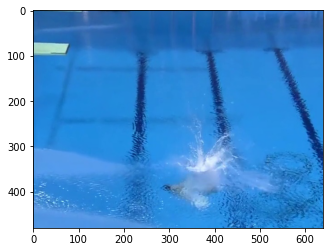

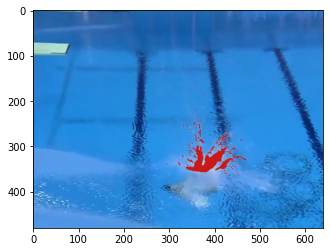

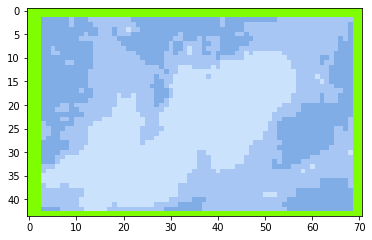

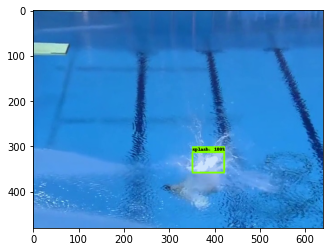

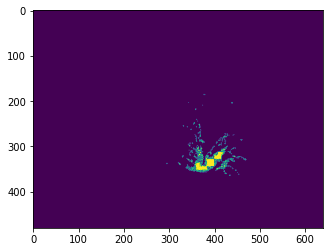

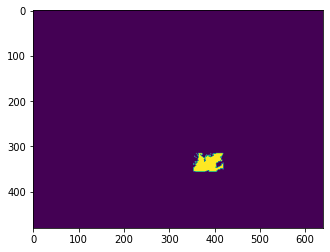

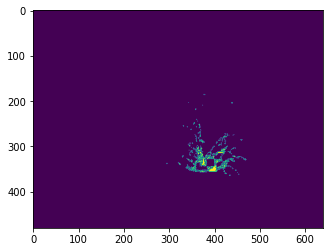

{'frame_name': '_tigfCJFLZg_00041.mp4_0153.0.jpg', 'label_size': 2048, 'splash_size': 1963, 'diff_size': 1623, 'accuracy': 0.2075}


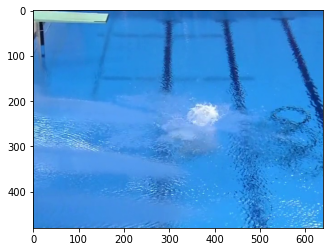

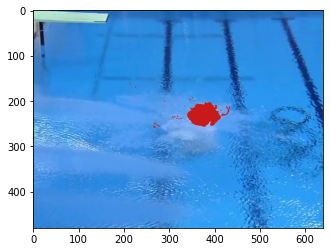

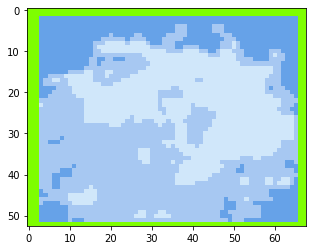

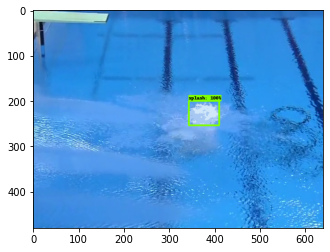

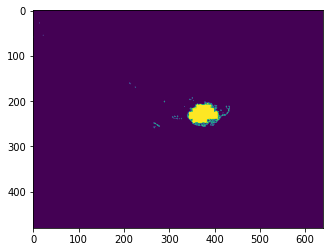

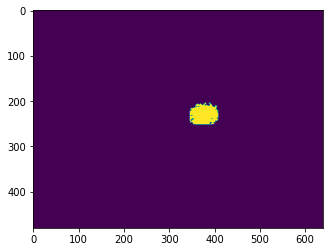

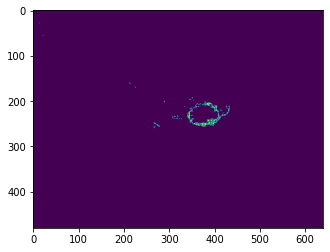

{'frame_name': '_tigfCJFLZg_00045.mp4_0193.0.jpg', 'label_size': 2497, 'splash_size': 2434, 'diff_size': 711, 'accuracy': 0.7153}


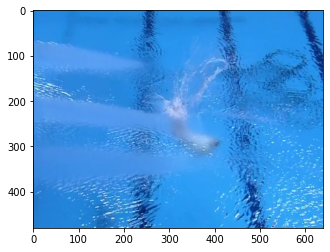

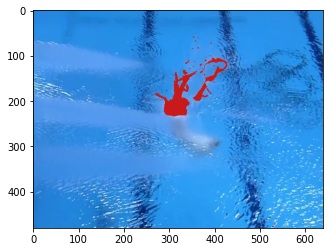

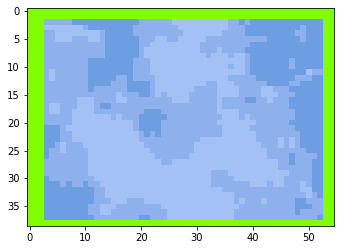

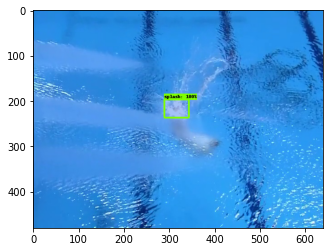

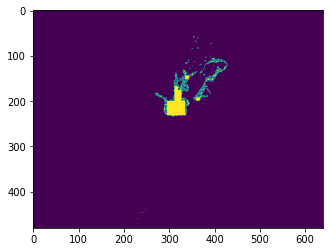

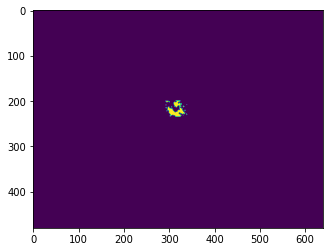

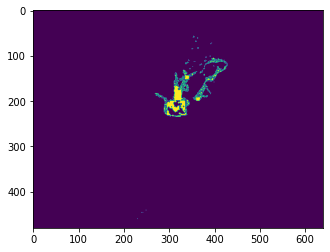

{'frame_name': '_tigfCJFLZg_00012.mp4_0140.0.jpg', 'label_size': 3413, 'splash_size': 651, 'diff_size': 2858, 'accuracy': 0.1626}


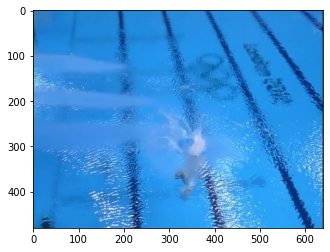

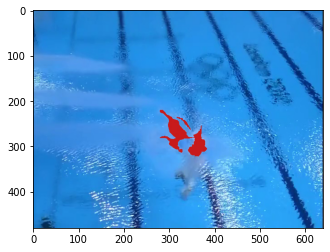

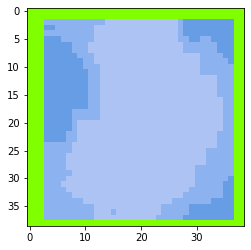

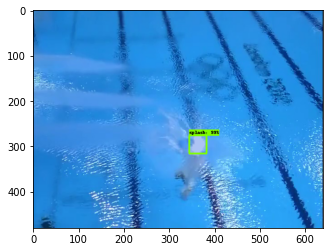

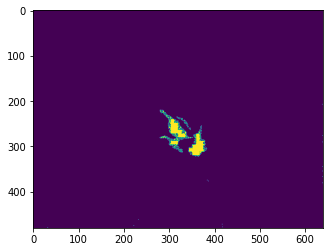

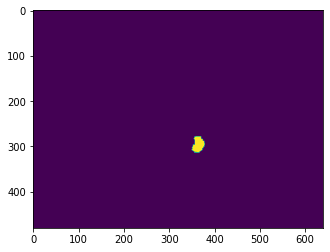

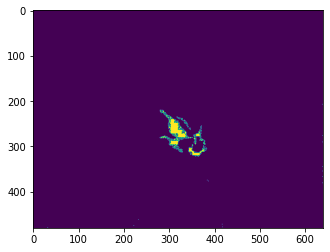

{'frame_name': '_tigfCJFLZg_00024.mp4_0108.0.jpg', 'label_size': 2566, 'splash_size': 724, 'diff_size': 2006, 'accuracy': 0.2182}


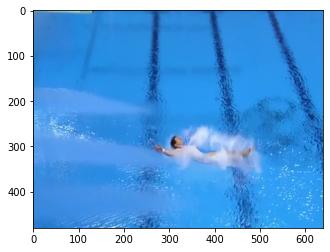

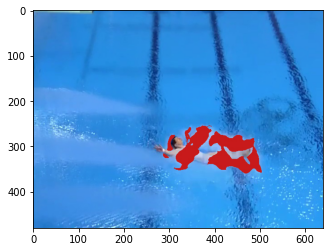

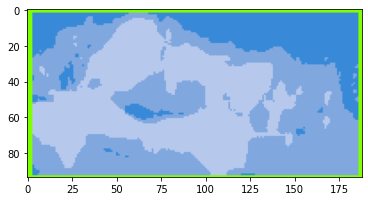

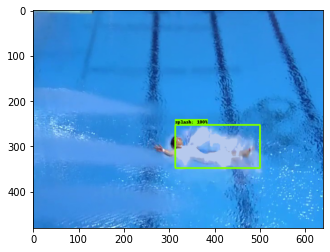

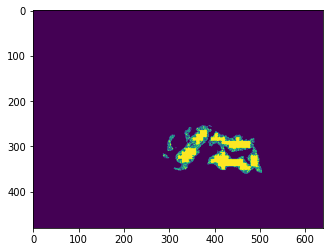

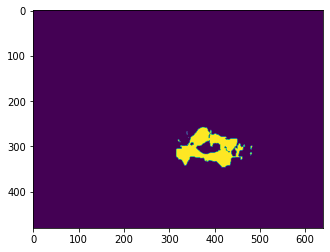

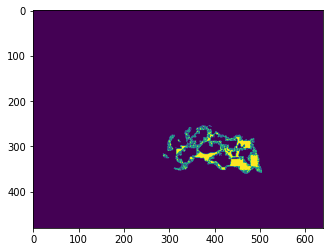

{'frame_name': '_tigfCJFLZg_00113.mp4_0126.0.jpg', 'label_size': 7316, 'splash_size': 6196, 'diff_size': 5442, 'accuracy': 0.2562}


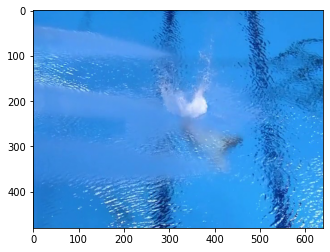

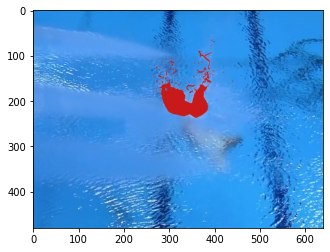

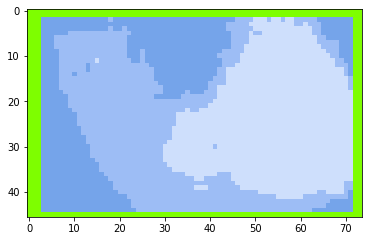

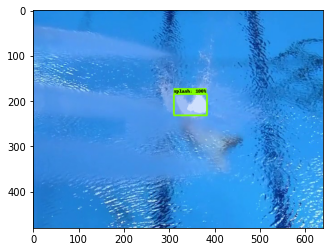

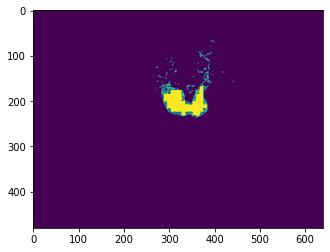

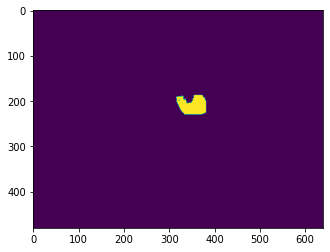

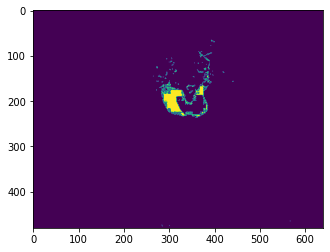

{'frame_name': '_tigfCJFLZg_00022.mp4_0141.0.jpg', 'label_size': 4492, 'splash_size': 2155, 'diff_size': 2875, 'accuracy': 0.36}


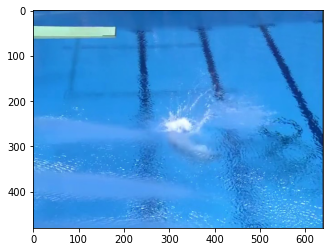

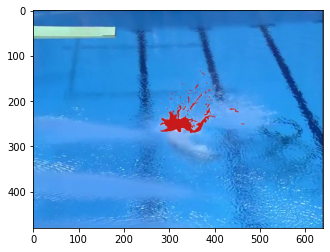

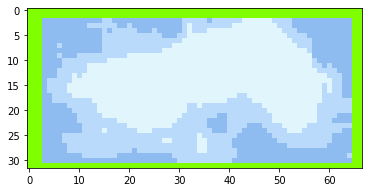

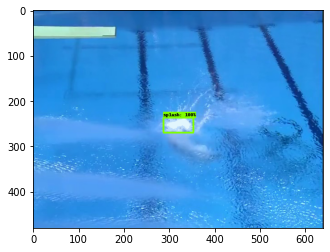

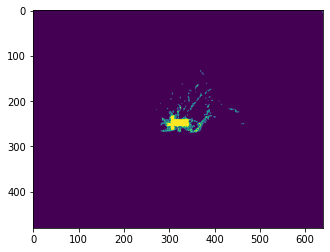

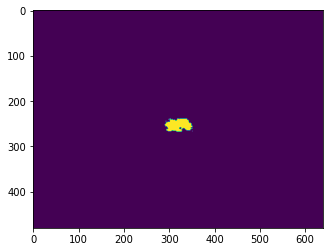

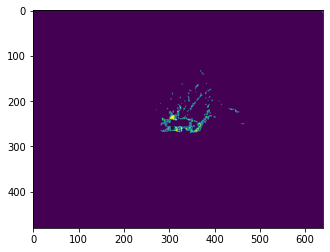

{'frame_name': '_tigfCJFLZg_00060.mp4_0034.0.jpg', 'label_size': 1930, 'splash_size': 1306, 'diff_size': 1234, 'accuracy': 0.3606}


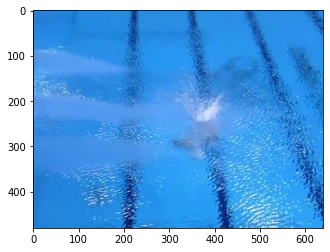

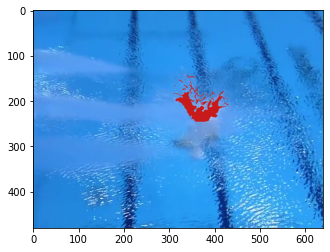

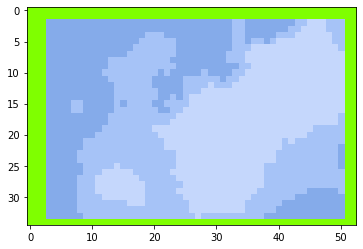

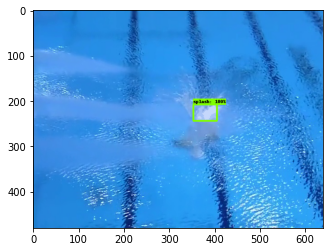

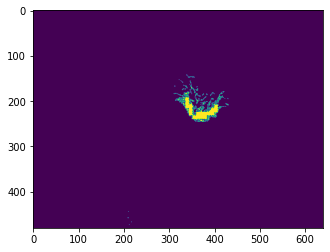

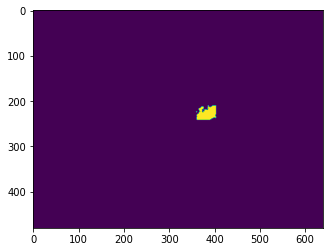

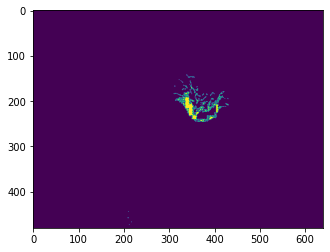

{'frame_name': '_tigfCJFLZg_00032.mp4_0167.0.jpg', 'label_size': 2289, 'splash_size': 1059, 'diff_size': 1736, 'accuracy': 0.2416}


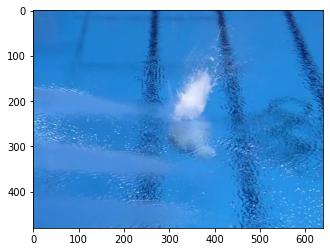

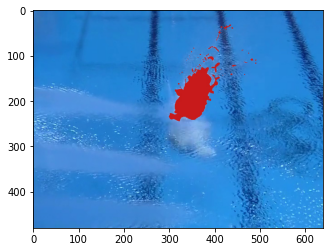

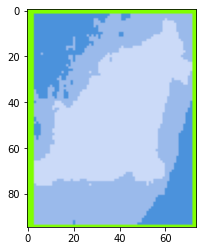

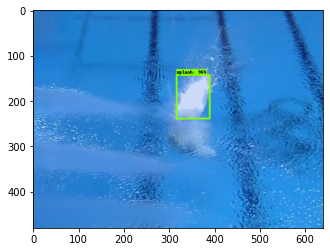

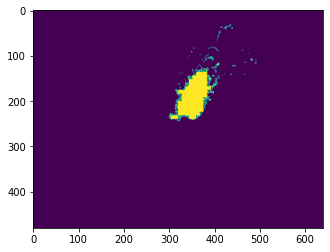

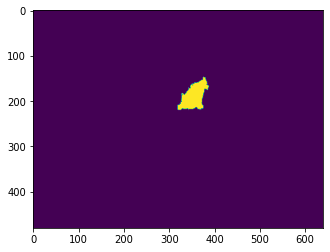

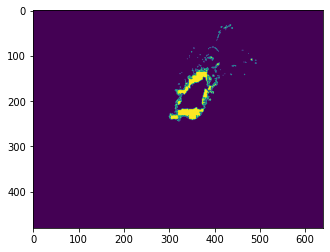

{'frame_name': '_tigfCJFLZg_00005.mp4_0145.0.jpg', 'label_size': 6163, 'splash_size': 2705, 'diff_size': 3480, 'accuracy': 0.4353}


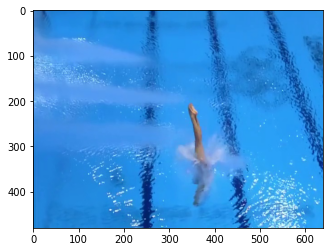

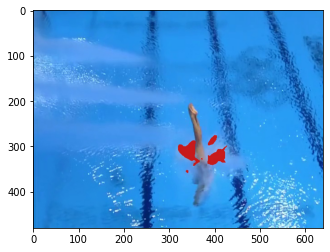

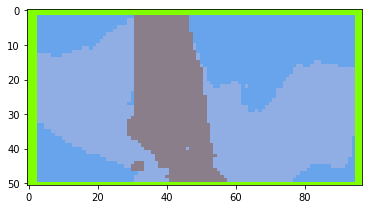

186


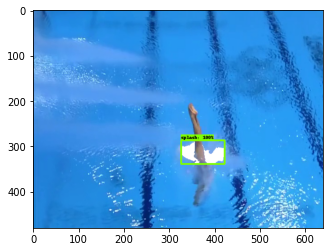

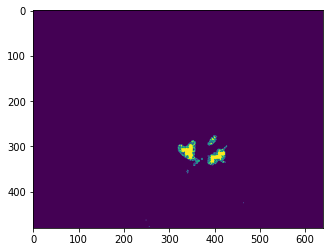

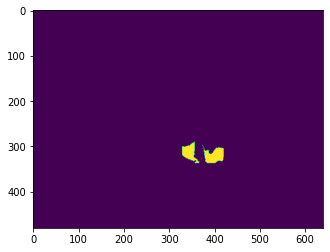

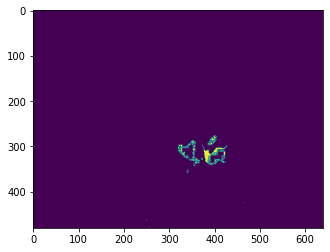

{'frame_name': '_tigfCJFLZg_00118.mp4_0175.0.jpg', 'label_size': 1724, 'splash_size': 2041, 'diff_size': 1255, 'accuracy': 0.272}


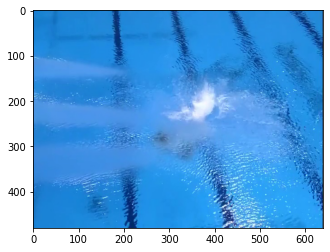

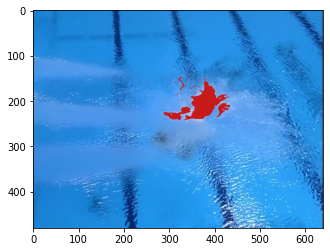

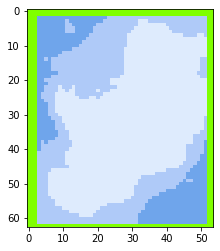

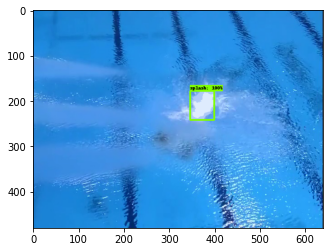

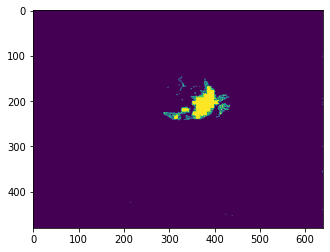

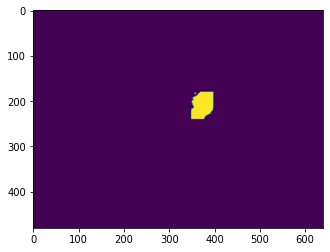

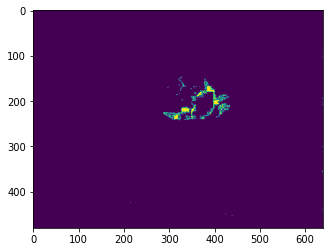

{'frame_name': '_tigfCJFLZg_00054.mp4_0092.0.jpg', 'label_size': 3506, 'splash_size': 2466, 'diff_size': 1814, 'accuracy': 0.4826}


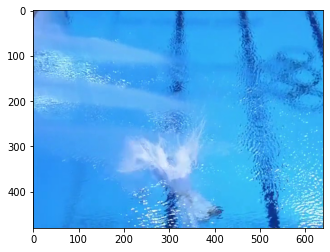

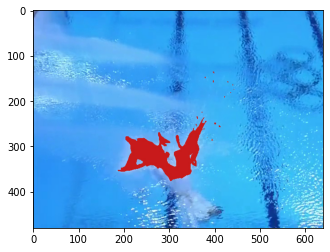

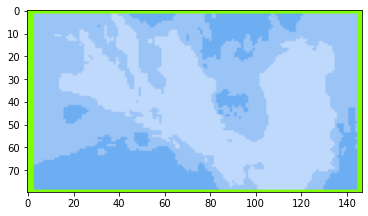

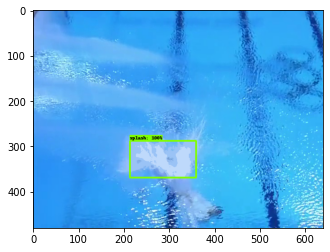

In [ ]:
accuracys_of_all_runs = []
for b in range(1):
    predictions = []
    for i in range(12):
        preddict = predict_and_plot(file_names[len(predictions)])
        predictions.append(preddict)

    all_labels_size = 0
    all_diff_sizes = 0
    for pre in predictions:
        all_labels_size += pre['label_size']
        all_diff_sizes += pre['diff_size']

    model_accuracy = round((all_labels_size - all_diff_sizes) / all_labels_size,4)
    print('run: ' +str(b+1), model_accuracy)
    accuracys_of_all_runs.append(model_accuracy)
    
print('over all accuracy', round(np.mean(accuracys_of_all_runs),4))